In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
import glob


In [19]:
# initial parameters
epochs = 100
learning_rate = 1e-3
batch_size = 64
img_dims = (64,64,3)  #(w , H , 3 chanells {RGP})

In [20]:
data = []
labels = []

# load image files from the dataset
image_files = [f for f in glob.glob(r'D:\DL\Gender Detection\Data\gender_dataset_face' + "/**/*", recursive=True) if not os.path.isdir(f)]
random.shuffle(image_files)
# using glob to find the all pathnames matching

In [21]:

for img in image_files:

    image = cv2.imread(img) #im read to read all images 
    
    image = cv2.resize(image, (img_dims[0],img_dims[1]))
    image = img_to_array(image)
    data.append(image)

    label = img.split(os.path.sep)[-2] # D:\DL\gender detection\gender_dataset_face\woman\face_1162.jpg
    if label == "woman":
        label = 1
    else:
        label = 0
        
    labels.append([label]) # [[1], [0], [0], ...]

# pre-processing
# Assuming 'data' is a list of loaded images
# Convert the list of images to a numpy array and set the data type to float32
data = np.array(data, dtype="float32") / 255.0 # ivided by 255.0 to make a normialization
labels = np.array(labels)

# split dataset for training and validation
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2,
                                                  random_state=42)
# to_categorical function converts a class vector (integers) to a binary class matrix.
trainY = to_categorical(trainY, num_classes=2) # [[1, 0], [0, 1], [0, 1], ...]
testY = to_categorical(testY, num_classes=2) 

# augmenting datset 
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")


In [22]:
def build(width, height, depth, classes): #lasses will be 2 because we have 2 categories
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1  # using for normalization 

    if K.image_data_format() == "channels_first": #Returns a string, either 'channels_first' or 'channels_last'
        inputShape = (depth, height, width)
        chanDim = 1 # using for normalization 
    
    # The axis that should be normalized, after a Conv2D layer with data_format="channels_first", 
    # set axis=1 in BatchNormalization.

    model.add(Conv2D(32, (3,3), padding="same", input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())  # make a 2 dimension in 1 single dimention
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(classes))
    model.add(Activation("sigmoid"))  #or i can use tha soft max

    return model


In [23]:
# build model
model = build(width=img_dims[0], height=img_dims[1], depth=img_dims[2],
                            classes=2)

# compile the model
opt = Adam(learning_rate=learning_rate, decay=learning_rate/epochs)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the model
H = model.fit(aug.flow(trainX, trainY, batch_size=batch_size),
                        validation_data=(testX,testY),
                        steps_per_epoch=len(trainX) // batch_size,
                        epochs=epochs, verbose=1)

# save the model to disk
model.save('gender_detection.keras')

C:\Users\Abdulrhman Saleh\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/100


C:\Users\Abdulrhman Saleh\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
C:\Users\Abdulrhman Saleh\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 610ms/step - accuracy: 0.5900 - loss: 0.9980 - val_accuracy: 0.7393 - val_loss: 0.6579
Epoch 2/100
 1/17 ━━━━━━━━━━━━━━━━━━━━ 7s 491ms/step - accuracy: 0.6406 - loss: 1.0360

C:\Users\Abdulrhman Saleh\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.6406 - loss: 0.5485 - val_accuracy: 0.7429 - val_loss: 0.6618
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 500ms/step - accuracy: 0.7235 - loss: 0.7693 - val_accuracy: 0.7357 - val_loss: 0.6143
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7188 - loss: 0.3157 - val_accuracy: 0.7357 - val_loss: 0.6077
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 366ms/step - accuracy: 0.7412 - loss: 0.6035 - val_accuracy: 0.7357 - val_loss: 0.5805
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8281 - loss: 0.2304 - val_accuracy: 0.7357 - val_loss: 0.5847
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 324ms/step - accuracy: 0.7854 - loss: 0.4975 - val_accuracy: 0.7357 - val_loss: 0.5595
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8594 - loss: 0.2112 - val_accuracy: 0.7357 - val_loss: 0.5623
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 375ms/step - accuracy: 0.8473 - loss: 0.4025 - val_accuracy: 0.7357 - 

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 1.0000 - loss: 0.0128 - val_accuracy: 0.8821 - val_loss: 0.3025
Epoch 53/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 418ms/step - accuracy: 0.9533 - loss: 0.1238 - val_accuracy: 0.9500 - val_loss: 0.1202
Epoch 54/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8906 - loss: 0.1114 - val_accuracy: 0.9536 - val_loss: 0.1061
Epoch 55/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 410ms/step - accuracy: 0.9501 - loss: 0.1199 - val_accuracy: 0.9750 - val_loss: 0.0759
Epoch 56/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9844 - loss: 0.0229 - val_accuracy: 0.9714 - val_loss: 0.0811
Epoch 57/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 428ms/step - accuracy: 0.9424 - loss: 0.1411 - val_accuracy: 0.9429 - val_loss: 0.1321
Epoch 58/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9844 - loss: 0.0356 - val_accuracy: 0.9393 - val_loss: 0.1543
Epoch 59/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 411ms/step - accuracy: 0.9401 - loss: 0.1410 - val_accuracy: 0.9

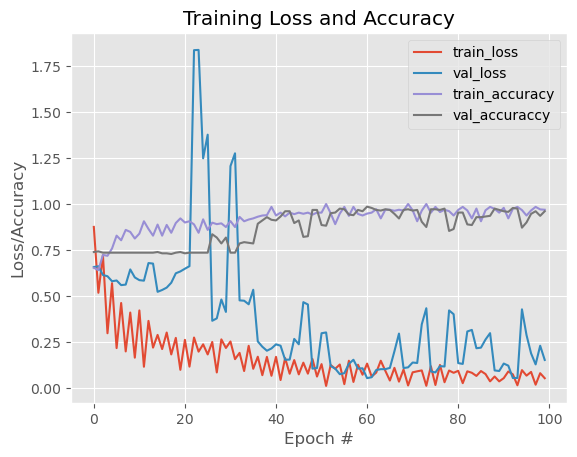

In [25]:
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0,N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), H.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0,N), H.history["val_accuracy"], label="val_accuraccy")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
